In [1]:
from tensorflow.keras import models, layers, utils, backend as K
import matplotlib.pyplot as plt
import shap

2023-02-19 00:06:09.040490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ANN - artificial neural network
# made of layers with an input and output dimension
# output is determined by # of neurons (nodes), a computational unit that connects weighted input through an activation function (helps neuron to switch on/off)
# weights are randomly initialized and optimized during training to minize a loss function

# Input layer - passes input vector to the neural netowrk. Matrix with 3 features takes 3 numbers as input and passes to next layer
# Hidden laters - intermediary nodes which apply transofrmations to numbers to improve accuracy of final result, and output is defined by number of neurons
# Output layer - returns final output of the nueral network

# simplest form of ANN is the perceptronm a model with only 1 later. similar to linear regression model

# "training a model" means to search for best paramteres to minimize error of predictions
# in regression models - find best weights, in tree-based models - find best splitting points
# upgrade from linear model - Σ(x_i * w_i) to non-linear f(Σ(x_i * w_i)) = Y using the activation function
# activation function triggers/applies after calculating weightage?
# training of the model compares output with target, calulating error and optimizes weights, reiterating the whole process again and again

# "Deep" Learning applies when algorithm has at least 2 hidden layers (4 total)
# If neuron process is replicated 3 times to create 3 neurons in one layer (hidden), then that hidden layer's neuron values can be used inputs for 2nd hidden layers, which is connected to final output layer (1 node only)

# Keep in mind
# Bias: the linear combination of inputs and weights includes a bias for each neuron so the full formala is f(Σ(x_i * w_i)+BIAS)
# Back propagation: during trainig, the model learns by propagating error back into nodes and updating paramters (weights and biases) to minimize loss
# Gradient descent: optimization algorithm used to tran neural networks which find the local minimum of the loss function by taking repeated steps in the direction of steepest descent

In [3]:
# easiest way to build ANN with tensorflow is with the Sequential class of Keras
# Perceptron is a model with only 1 dense later
model = models.Sequential(name="Perceptron", layers = [
    layers.Dense(           # a fully connected layer
        name="dense",
        input_dim=3,        # 3 features as input
        units=1,            # 1 node to be output
        activation='linear' # f(x) = x
    )
])
model.summary() # snapshot of structure and size (in terms of paramaters to train)
# in this case, 3 weights and 1 bias which is why it says 4 paramaters

Model: "Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


2023-02-19 00:06:21.640544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import tensorflow as tf
# to use activation function not in Keras, the function must be implemented manually / created raw

# define the function
def binary_step_activation(x):
    # return 1 if x> 0 else 0
    return K.switch(x>0, tf.math.divide(x,x), tf.math.multiply(x,0))

# build the model
model = models.Sequential(name='Perceptron', layers=[
    layers.Dense(
        name='dense', 
        input_dim=3, 
        units=1, 
        activation=binary_step_activation
    )
])
model.summary()

Model: "Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None)              4         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Moving from the Perceptron to a Deep Neural Network
# How many layers? Try different variants and see what works. 
    # Hidden layers are useful to overcome the non-linearity of data, so if non-linearity is not needed then avoid hidden layers
    # Too many hidden layers will lead to overfitting
# How many neurons? 
    # Number of neurons should be between the size of input layer and size of output layer
    # A rule of thumb - # of neurons = (# of inputs + 1 output)/2
# What activation function?
    # Most used one is ReLU, a piecewise linear function that returns the output only if it's positivee, and mainly used for hidden layers 
    # Linear function is stuited for regression problems
    # Sigmoid function is frequently used for classification

n_features = 10

model = models.Sequential(name="DeepNN", layers = [
    # hidden layer 1
    layers.Dense(name='h1', input_dim=n_features, units=int(round((n_features+1)/2)), activation='relu'),
    layers.Dropout(name='drop1', rate=0.2), # Dropout - a technique that reduces overfitting by randomly setting inputs to 0

    # hidden layer 2
    layers.Dense(name="h2", units=int(round((n_features+1)/4)), activation='relu'),
    layers.Dropout(name="drop2", rate=0.2),

    # layer output
    layers.Dense(name='output', units=1, activation='sigmoid')
])
model.summary()


Model: "DeepNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 6)                 66        
                                                                 
 drop1 (Dropout)             (None, 6)                 0         
                                                                 
 h2 (Dense)                  (None, 3)                 21        
                                                                 
 drop2 (Dropout)             (None, 3)                 0         
                                                                 
 output (Dense)              (None, 1)                 4         
                                                                 
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Sequential class isn't the only way to build a neural netword with Keras
# Model class gives more flexibility and control over layers, and can be used to build more cimplex models with multiple inputs/outputs
# Differences:
    # Input later needs to be specified in Model class while in the Sequential class it's implied
    # The layers are saved like ojects and can be applied to the outputs of other layers like: output = layer(...)(input)

# Perceptron
inputs = layers.Input(name='input', shape=(3,))
outputs = layers.Dense(name='output', units=1, activation='linear')(inputs)
p_model = models.Model(inputs=inputs, outputs=outputs, name='Perceptron')

# DeepNN
# layer input
inputs = layers.Input(name='input', shape=(n_features,))

# hidden layer 1
h1 = layers.Dense(name='h1', units=int(round((n_features+1)/2)), activation='relu')(inputs)
h1 = layers.Dropout(name='drop1', rate=0.2)(h1)

# hidden layer 2
h2 = layers.Dense(name='h2', units=int(round((n_features+1)/4)), activation='relu')(h1)
h2 = layers.Dropout(name='drop2', rate=0.2)(h2)

#layer output
outputs = layers.Dense(name='output', units=1, activation='sigmoid')(h2)

deepNN_model = models.Model(inputs=inputs, outputs=outputs, name='DeepNN')

In [7]:
'''
Extract info for each layer in a keras model.
'''
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential doesn't show the input layer
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0, 
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units, 
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0, 
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers



'''
Plot the structure of a keras neural network.
'''
def visualize_nn(model, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]
    
    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    
    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color
        
        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        
        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/4.0, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            
            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    
    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left], 
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space], 
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()

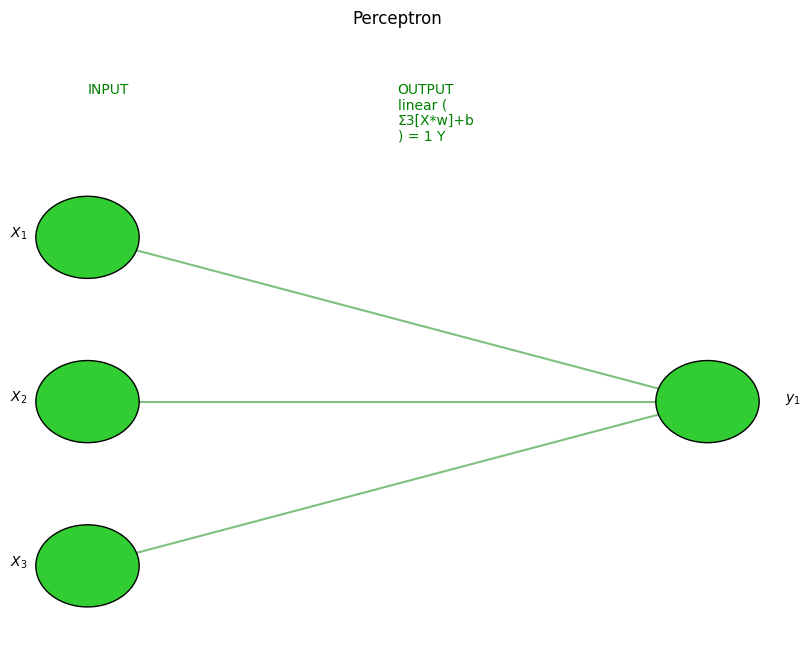

In [8]:
visualize_nn(p_model, description=True, figsize=(10,8))

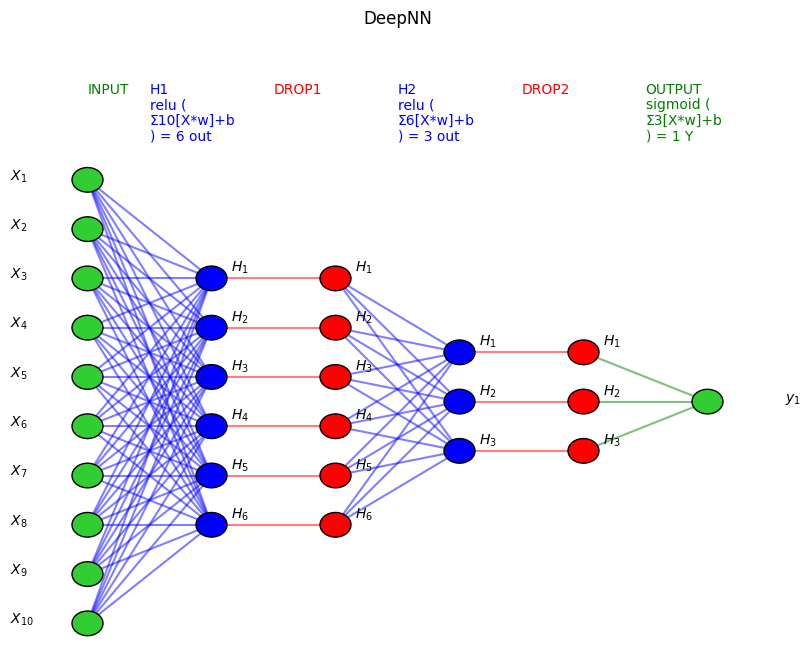

In [9]:
visualize_nn(deepNN_model, description=True, figsize=(10,8))

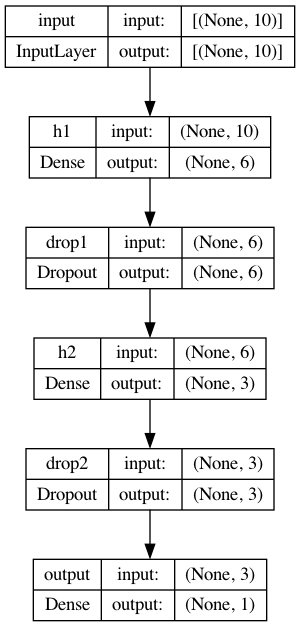

In [17]:
utils.plot_model(deepNN_model, show_shapes=True, show_layer_names=True)

In [11]:
# Training the Deep Learning model
# Need to define the optimizer, the loss function and the metrics
# Best Adaptive Optimizer - Adam optimizer, a replacement optimization algorothm for gradient descent
# In (binary) classification problems best loss function = (binary) Cross-Entropy loss which compares each of the predicted probabilities to the actual class output
# Metric - Accuracy and the F1-score, a metric that combines Precision and Recall
# Regression problems, loss function = MAE and metric = R-squared

# define metrics
def Recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def Precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def F1(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
def R2(y, y_hat):
    ss_res =  K.sum(K.square(y - y_hat)) 
    ss_tot = K.sum(K.square(y - K.mean(y))) 
    return ( 1 - ss_res/(ss_tot + K.epsilon()) )

# compile the neural network
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[R2])

In [12]:
# need to decide Epochs and Batches before training since dataset might be too large to process all at once
# An epoch is one pass over the full training set
# A batch is how much data of the epoch to take in at once, which should be a multiple of 2 because computers usually organize memory in power of 2
# During training expect metrics to improve and loss to decrease epoch by epoch

import numpy as np
X = np.random.rand(1000,10)
y = np.random.choice([1,0], size=1000)

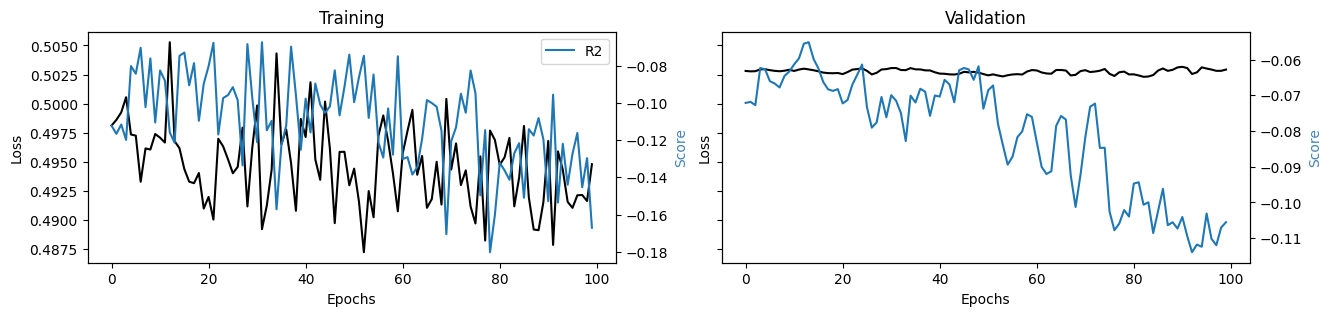

In [13]:
# train / validation
training = model.fit(x=X, y=y, batch_size=32, epochs=100, shuffle=True, verbose=0, validation_split=0.3)

# plot
metrics = [k for k in training.history.keys() if ("loss" not in k) and ('val' not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
       
## training    
ax[0].set(title="Training")    
ax11 = ax[0].twinx()    
ax[0].plot(training.history['loss'], color='black');        ax[0].set_xlabel('Epochs')    
ax[0].set_ylabel('Loss', color='black')    
for metric in metrics:        
    ax11.plot(training.history[metric], label=metric);      ax11.set_ylabel("Score", color='steelblue')    
ax11.legend()
        
## validation    
ax[1].set(title="Validation")    
ax22 = ax[1].twinx()    
ax[1].plot(training.history['val_loss'], color='black');        ax[1].set_xlabel('Epochs')    
ax[1].set_ylabel('Loss', color='black')    
for metric in metrics:          
    ax22.plot(training.history['val_'+metric], label=metric);   ax22.set_ylabel("Score", color="steelblue")    
plt.show()

In [14]:
# Shap - helps to explain results by estimating contribution of each feature to the value predicted by the model
'''
Use shap to build an a explainer.
:parameter
    :param model: model instance (after fitting)
    :param X_names: list
    :param X_instance: array of size n x 1 (n,)
    :param X_train: array - if None the model is simple machine learning, if not None then it's a deep learning model
    :param task: string - "classification", "regression"
    :param top: num - top features to display
:return
    dtf with explanations
'''
def explainer_shap(model, X_names, X_instance, X_train=None, task="classification", top=10):
    ## create explainer
    ### machine learning
    if X_train is None:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_instance)
    ### deep learning
    else:
        explainer = shap.DeepExplainer(model, data=X_train[:100])
        shap_values = explainer.shap_values(X_instance.reshape(1,-1))[0].reshape(-1)

    ## plot
    ### classification
    if task == "classification":
        shap.decision_plot(explainer.expected_value, shap_values, link='logit', feature_order='importance',
                           features=X_instance, feature_names=X_names, feature_display_range=slice(-1,-top-1,-1))
    ### regression
    else:
        shap.waterfall_plot(explainer.expected_value[0], shap_values, 
                            features=X_instance, feature_names=X_names, max_display=top)

In [15]:
# Calls the explainer_shap method, but doesn't work with the data given
# i = 1
# explainer_shap(model, 
#                X_names=list_feature_names, 
#                X_instance=X[i], 
#                X_train=X, 
#                task="classification", #task="regression"
#                top=10)